# Predicting Blue-Chip Company Financial Trajectory

---

The objective is to measure a company’s financial health trajectory indicated by the equity value of the company using regression and classification models. The libraries used are Scikit-Learn and TensorFlow. 

We will predict the annual market capitalization ("market cap") using annual data (e.g., year-end market cap for 2025). The financial metrics we used are from a 2024 dataset for Fortune 1000 companies, and additional financial metrics we worked with are from 10-K reports found on the SEC database (More information on data sources is in the README.md and project deliverables).

In this project, we will perform:
1. **Regression**: Predicting the annual market cap using annual data (e.g., year-end market cap for 2025). The financial metrics we use include revenue, profits, EBITDA, and other key indicators.
2. **Classification**: Classifying companies as **growth** or **non-growth** based on financial health metrics like EBITDA margins.

In [ ]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
import imblearn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer

# Imports we used during regression 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2

# Imports we used for classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score,  average_precision_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve,classification_report,ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler




In [194]:
# Load data
initial_df = pd.read_csv('data/FinancialData.csv')
initial_df.head()

,Company,Sector,Industry,Profitable,Number_of_employees,MarketCap_March28_M,Revenues_M,RevenuePercentChange,Profits_M,ProfitsPercentChange,Assets_M,CompanyType,MarketCap_Updated_M,EBITDA,EBITDA_Margin
0,Walmart,Retailing,General Merchandisers,yes,2100000,484852.8,648125.0,6.0,15511.0,32.8,252399.0,Public,559911.0,3.638400e+10,56137.319190
1,Amazon,Retailing,Internet Services and Retailing,yes,1525000,1873675.8,574785.0,11.8,30425.0,NaN,527854.0,Public,2005565.0,1.134840e+11,197437.302644
2,Apple,Technology,"Computers, Office Equipment",yes,161000,2647973.8,383285.0,-2.8,96995.0,-2.8,352583.0,Public,3594309.0,1.346610e+11,351333.863835
3,UnitedHealth Group,Health Care,Health Care: Insurance and Managed Care,yes,440000,456080.8,371622.0,14.6,22381.0,11.2,273720.0,Public,474339.0,2.790400e+10,75087.050820
4,Berkshire Hathaway,Financials,Insurance: Property and Casualty (Stock),yes,396500,908919.7,364482.0,20.7,96223.0,NaN,1069978.0,Public,937028.0,NaN,0.000000


## I. Preparing the data
We will analyze and visualize `FinancialData.csv`, inlcuding handling missing data, investigating and handling class imbalance, post-processing, and other data preparation methods.


Our **target** variable that we are aiming to predict is market cap. We have the following metrics:

1. *Revenue* (e.g., Revenues_M, RevenuePercentChange).
2. *Profit and earnings* (e.g., Profits_M, ProfitsPercentChange, EBITDA).
3. *Company assets* (e.g., Assets_M).

*Note*: As you can already tell, some metrics may introduce multicollinearity into the dataset. 

The other features (Worlds_Most_Admired_Companies, Best_Companies_to_Work_For, and other features) are generally irrelevant for predicting financial metrics like market cap. In `generate.py`, we removed these irrelevant columsns to create a dataset with only relevant features. Next, we will handle missing values and correlated features.

### **Part 1: Exploratory Data Analysis**


In [195]:
initial_df = initial_df.dropna(subset=['MarketCap_March28_M'])
initial_df = initial_df.drop(columns=['Company'])

**Compare market cap by Categorical Variables Industry and Company Type**

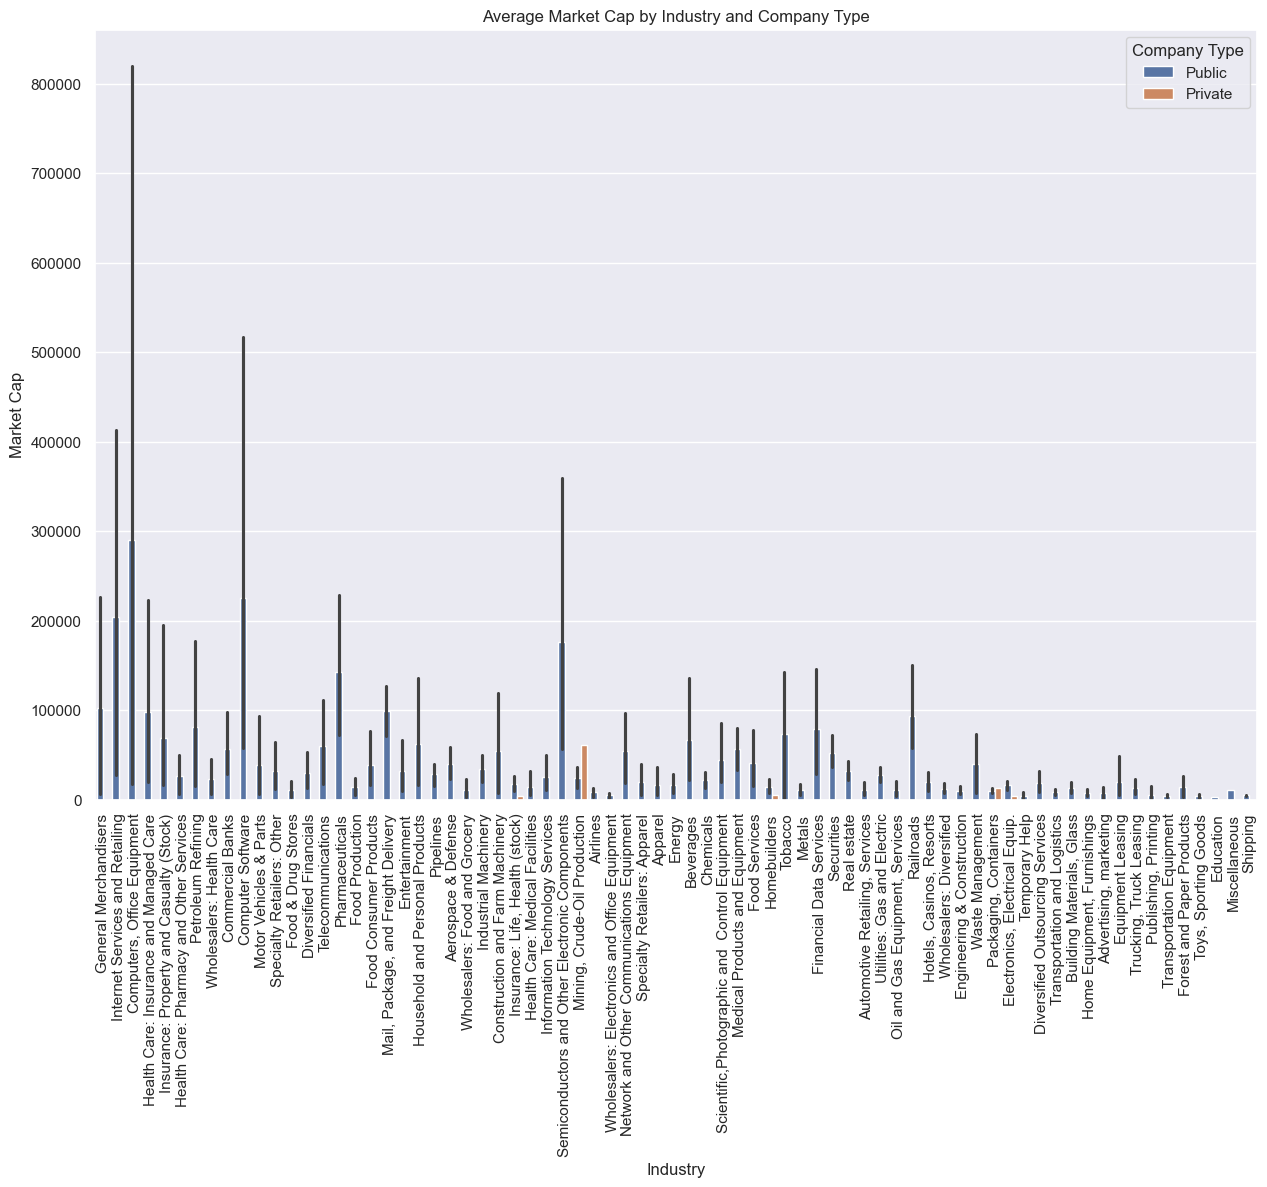

In [ ]:
plt.figure(figsize=(15, 10)) 

sns.barplot(initial_df, x="Industry", y="MarketCap_March28_M", hue="CompanyType")

# Labels
plt.title(f"Average market cap by Industry and Company Type")
plt.xlabel("Industry")
plt.ylabel("market cap")
plt.xticks(rotation=90)
plt.legend(title='Company Type')

plt.show()

**Visualize data distributions for categorical variables**

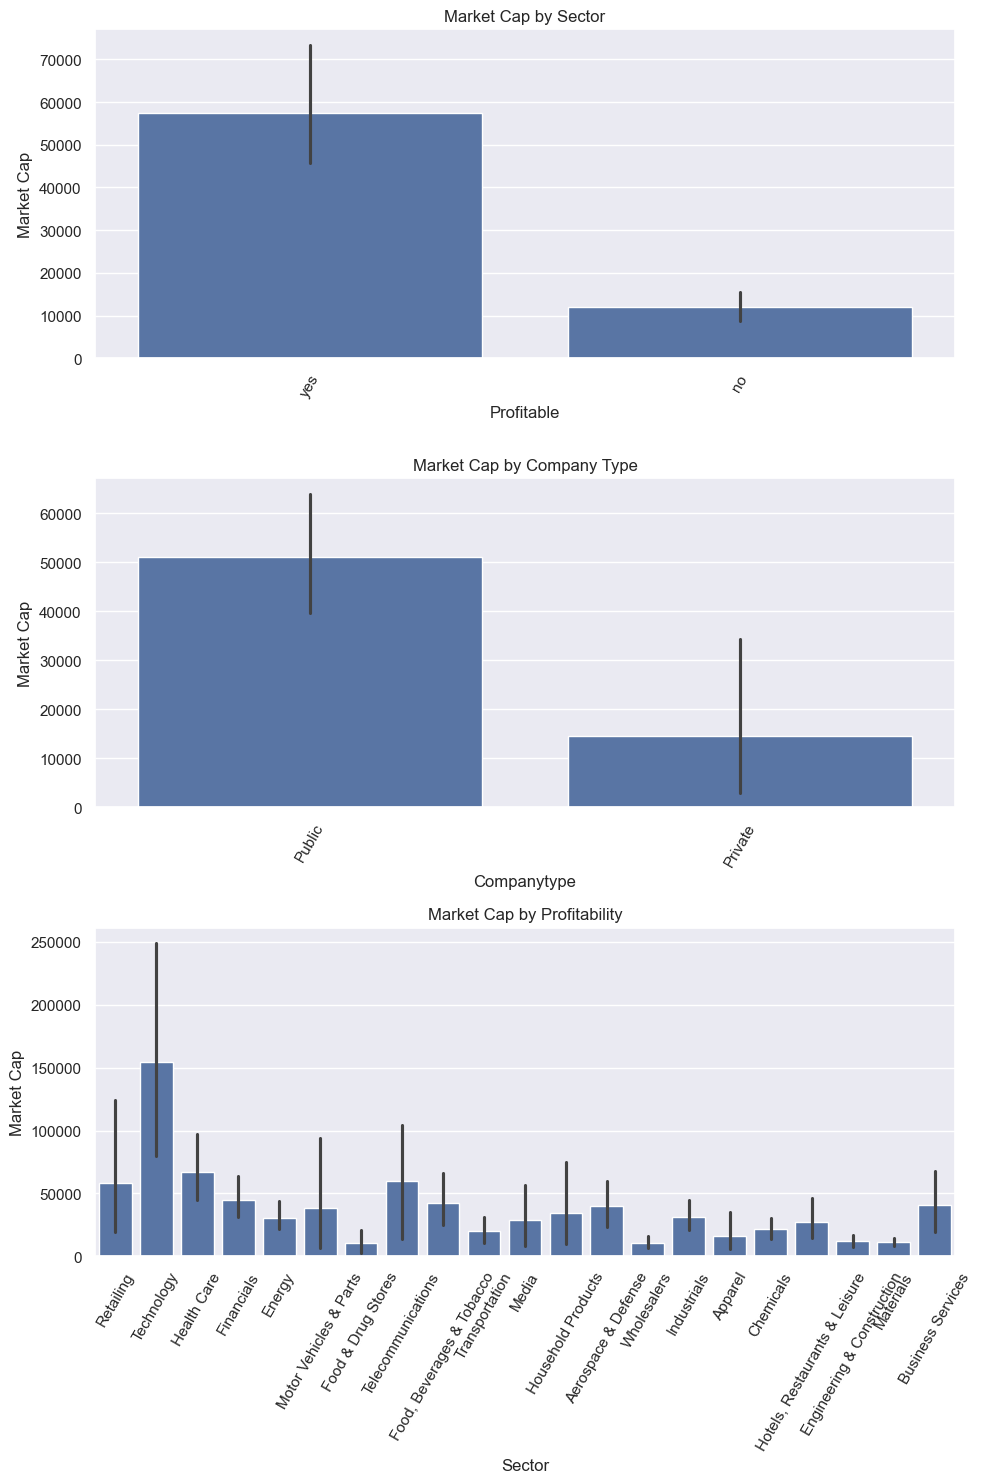

In [ ]:
categorical_variables = ["Profitable", "CompanyType", "Sector"]


fig, ax = plt.subplots(3, 1, figsize=(10, 15))

subplot_titles = {
    "market cap by Sector", 
    "market cap by Profitability",
    "market cap by Company Type",
}

for var, title, subplot in zip(categorical_variables, subplot_titles, ax.flatten()):
    sns.barplot(x=var, y="MarketCap_March28_M", data=initial_df, ax=subplot)
    subplot.set_xlabel(var.capitalize())
    subplot.set_ylabel("market cap")
    subplot.set_title(title)
    plt.setp(subplot.xaxis.get_majorticklabels(), rotation=60)

plt.tight_layout()
plt.show()

**Compare the market cap by Revenue and EBITDA**

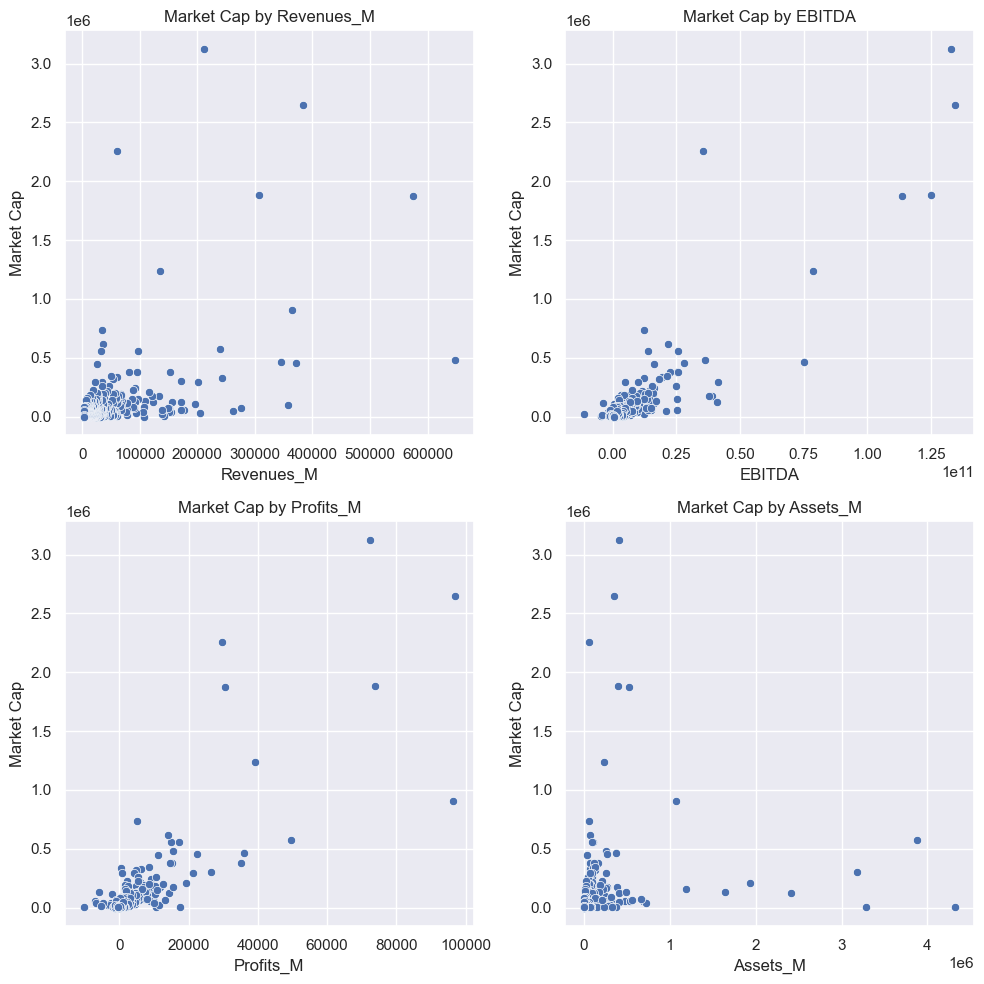

In [ ]:
# Plot scatter plots for numerical features vs. market cap
num_features = ["Revenues_M", "EBITDA", "Profits_M", "Assets_M"]

fig, ax = plt.subplots(2,2, figsize=(10,10))

for var, subplot in zip(num_features, ax.flatten()):
    sns.scatterplot(x=var, y="MarketCap_March28_M", data=initial_df, ax=subplot)
    
    # Labels
    subplot.set_xlabel(var)
    subplot.set_ylabel("market cap")
    subplot.set_title(f"market cap by {var}")


plt.tight_layout()
plt.show()

### **Part 2: Data Preprocessing**

Financial data is typically imbalanced, and, as we saw in our results above, much of the data is skewed. Before we can fit a linear regression model, several pre-processing steps should be applied to the dataset:
 
1. **Encode categorical features** (e.g., `Sector`, `Industry`, `CompanyType`).
2. **Handle multicollinearity** (remove highly correlated features).
3. **Split the dataset** into training, validation, and test sets.
4. **Handle outliers and scale the numerical features** to handle skewed data.
 

### Multicollinearity

Checking for high correlation is important because linear regression assumes independence, and it is difficult to ascertain a linear relationship between features with multilinearity. Dropping one category of each encoded variable is necessary before proceeding further to avoid collinear columns, which will result in a singular matrix. These matrices are not invertible, and therefore collinear columns affect if we can apply the closed form solution. It is also much easier to train the model after dropping the features with high correlations from the dataframe. 

**Plot the correlation matrix and drop highly correlated features.**

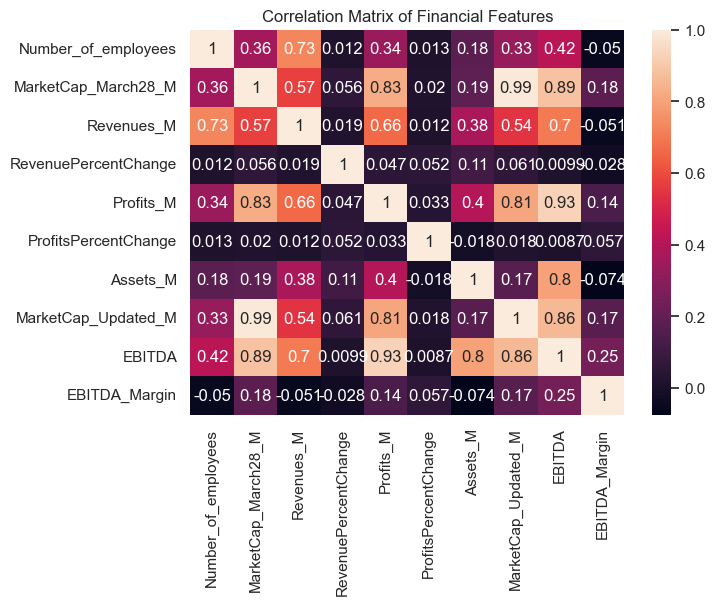

In [199]:
## Create correlation matrix

df_numeric = initial_df.select_dtypes(include=[np.number]) 
corr_matrix = df_numeric.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix of Financial Features')
plt.show()

**We will process the data by handling missing data, encoding the categorical variables, and applying standardization.**

We handled missing data by imputing the median. Additionally, in creating the dataset, we impute different values for EBITDA values that are missing (e.g., we imputed the LTM calculation into the cells with missing values). Note: we also dropped "EBITDA" because of its correlation with "EBITDA_Margins", where EBITDA margins were determined to be more important for our objective than the raw EBITDA values. 

In [200]:
# Handle missing values (we use `SimpleImputer()` to impute the median – especially because of the skewedness of our data)

imputer = SimpleImputer(strategy='median')
numeric_columns = initial_df.select_dtypes(include=[np.number]).columns
initial_df[numeric_columns] = imputer.fit_transform(initial_df[numeric_columns])

In [201]:
# Encode categorical features
encoded_df = pd.get_dummies(initial_df, columns=["Sector", "Industry", "CompanyType", "Profitable"], drop_first=True)

In [202]:
# Dropping highly correlated features

dropped = ['MarketCap_Updated_M', 'Profits_M', 'Number_of_employees'] 
df = encoded_df.drop(columns=dropped)

**Explanation of feature correlation**

Profits can oftentimes be proportional to market cap which explains the correlation between the variables. If a company is generating more profit, investors are more likely to want to invest in the company. These companies that are generating high profits will likely have more investors and consequently higher market cap.

In [203]:
# Pandas .quantile(): https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html
upper_limit = df['MarketCap_March28_M'].quantile(0.99)
lower_limit = df['MarketCap_March28_M'].quantile(0.01)

df['MarketCap_March28_M'] = np.clip(df['MarketCap_March28_M'], lower_limit, upper_limit)

for col in ['Revenues_M', 'Assets_M', 'EBITDA']:

    upper_limit = df[col].quantile(0.99)
    lower_limit = df[col].quantile(0.01)

    df[col] = np.clip(df[col], lower_limit, upper_limit)

### Dataset Split

**Split the dataset into training (60%), validation (20%), and test (20%) sets.**

In [204]:
X = df.drop(columns=['MarketCap_March28_M'])  
y = df['MarketCap_March28_M'] 

In [205]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Scale the data using `RobustScaler()`**

In [206]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We now have the following vectors and matrices:

- **X_train**: Training set feature matrix.
- **X_val**: Validation set feature matrix.
- **X_test**: Test set feature matrix.
- **y_train**: Training set labels (market cap).
- **y_val**: Validation set labels.
- **y_test**: Test set labels.

# II. Regression


We aim to predict annual market cap based on the financial metrics in our data. We will do this using several models and applying the supervised learning framework, which will include training the model, tuning hyperparamters (for the models following linear regression), and evaluating performance. We will first train a linear regression model. 

### Part 1: **Linear Regression Model**

We will create the model using scikit-learn's `LinearRegression()` and then evaluate the model.

**Evaluate the Linear Regression model**

In [207]:
# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)
y_test_pred = lr_model.predict(X_test)

**Linear Regression Model Evaluation**

In [208]:
# Evaluate the model
train_score = r2_score(y_train, y_train_pred)
val_score = r2_score(y_val, y_val_pred)
test_score = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training set R² coefficient: {train_score}")
print(f"Validation set R² coefficient: {val_score}")
print(f"Test set R² coefficient: {test_score}")
print(f"Training set RMSE: {train_rmse}")
print(f"Validation set RMSE: {val_rmse}")
print(f"Test set RMSE: {test_rmse}")

Training set R² coefficient: 0.724539548494701
Validation set R² coefficient: 0.6898456714410273
Test set R² coefficient: 0.739052872806991
Training set RMSE: 43457.501934738626
Validation set RMSE: 40949.61972993114
Test set RMSE: 47800.89998550059


**Analyzing Feature Importance**

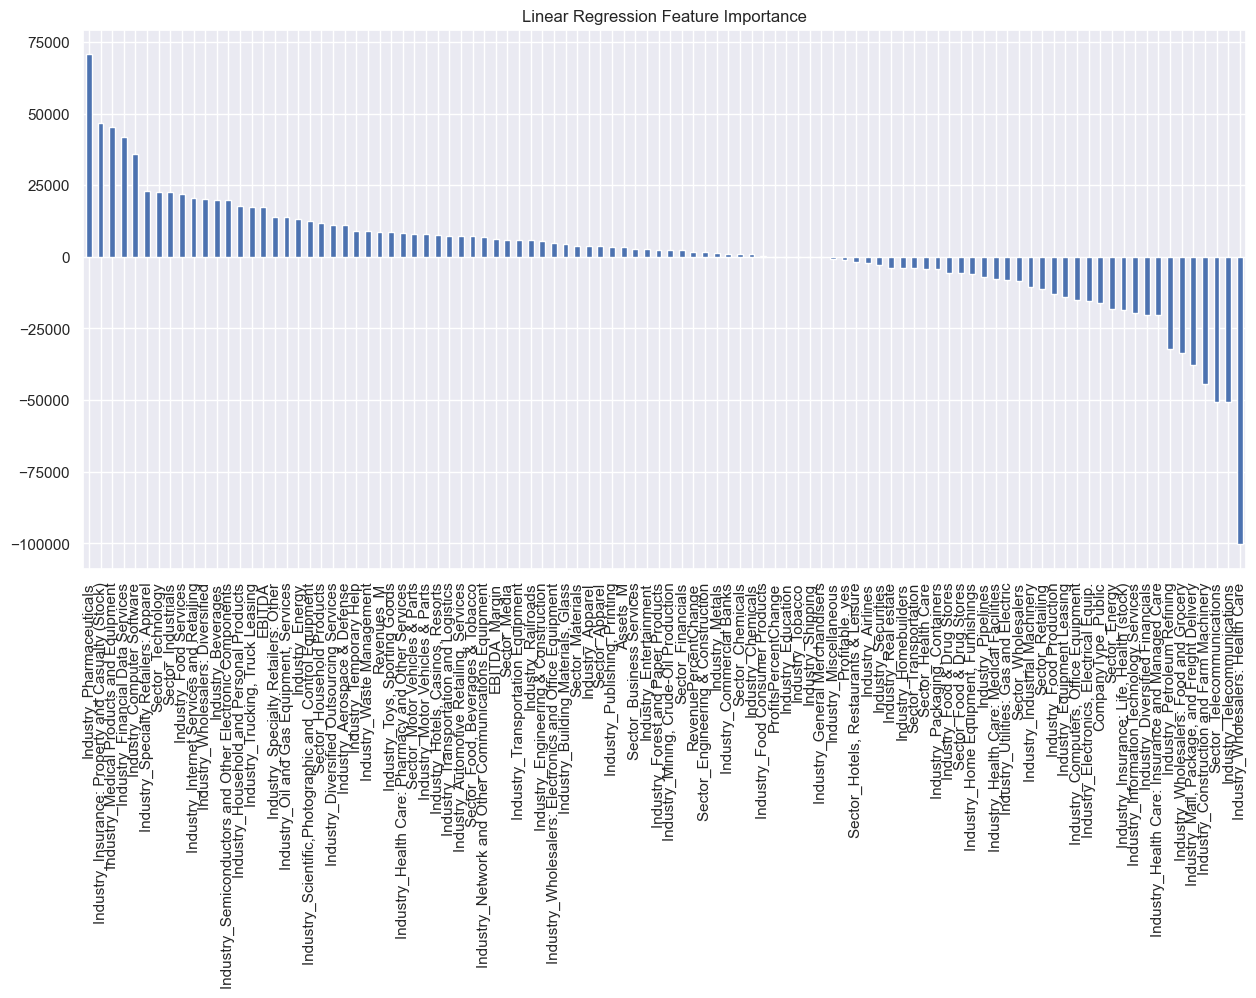

In [209]:
## plot most important features

feature_importance = pd.Series(lr_model.coef_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(15, 7))

plt.title('Linear Regression Feature Importance')
plt.show()

**Explanation of Feature Importance**

Industry (particularly healthcare-related industries) and certain sectors (e.g., telecommunications) seem to be a significant indication of a company's market cap value. Healthcare tends to grow significantly faster on the basis that pending launches of healthcare drugs will spike market cap severely. 

For instance, during the pandemic, Pfizer's market cap values shot up exponentionally alongside the release of COVID-19-related vaccinations and treatments. As a result, this industry is particularly sensitive to shocks in market cap.

### Part 2: **Ridge Regression**

We will perform Ridge Regression with hyperparameter tuning, and add additional models to analyze results. Lastly, we will evaluate the models. 

In [210]:
ridge = Ridge()

**2.1 Grid Search**

In [211]:
alpha_params = np.logspace(-5, 1, 20)
pipe = GridSearchCV(ridge, param_grid={"alpha": alpha_params}, return_train_score=True, cv=5)
pipe.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01])},
             return_train_score=True)

**Find best scores**

In [212]:
best_score = pipe.best_score_
best_alpha = pipe.best_params_
test_score = pipe.score(X_test, y_test)

print(f"Best score: {best_score}")
print(f"Best alpha: {best_alpha}") 
print(f"Test score: {test_score}")

Best score: 0.6073671377548407
Best alpha: {'alpha': np.float64(10.0)}
Test score: 0.7314836614641853


**Model Interpretation**

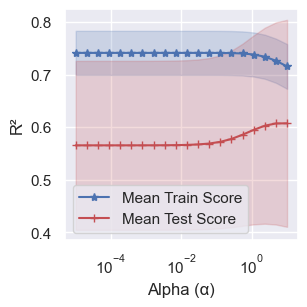

In [213]:
### Plot training and validation R^2 values as a function of alpha
mean_test_score = pipe.cv_results_["mean_test_score"]
std_test_score = pipe.cv_results_["std_test_score"]
mean_train_score = pipe.cv_results_["mean_train_score"]
std_train_score = pipe.cv_results_["std_train_score"]

sns.set()
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1, 1, 1)

# Mean train
plt.plot(alpha_params, mean_train_score, "b*-", label="Mean Train Score")
plt.fill_between(alpha_params, mean_train_score - std_train_score, mean_train_score + std_train_score, color="b", alpha=0.2)

# Mean test
plt.plot(alpha_params, mean_test_score, "r+-", label="Mean Test Score")
plt.fill_between(alpha_params, mean_test_score - std_test_score, mean_test_score + std_test_score, color="r", alpha=0.2)

plt.legend()
ax.set_xscale('log')

# Labels
plt.xlabel("Alpha (α)")
plt.ylabel("R²")

plt.show()

**Updated Ridge Regression model using α=10**

In [214]:
## use best ridge model

best_ridge = Ridge(alpha=10.0)
best_ridge.fit(X_train, y_train)

y_train_pred = best_ridge.predict(X_train)
y_val_pred = best_ridge.predict(X_val)
y_test_pred = best_ridge.predict(X_test)

**RMSE and R² Values**

In [215]:
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training set R²: {train_r2}")
print(f"Validation set R²: {val_r2}")
print(f"Test set R²: {test_r2}")

print(f"Training set RMSE: {train_rmse}")
print(f"Validation set RMSE: {val_rmse}")
print(f"Test set RMSE: {test_rmse}")


Training set R²: 0.7048563699794093
Validation set R²: 0.7163690509671186
Test set R²: 0.7314836614641853
Training set RMSE: 44983.3544343343
Validation set RMSE: 39159.55598668502
Test set RMSE: 48489.21706160448


# III. Neural Network

We will first train a Neural Network that will serve as a baseline. Then, we will integrate dropout and use L2 regularization with another Neural Network. We are using financial data, so we will use dense layers. Additionally, we will use **adam** as the optimizer and experiment with different batch sizes and epochs to determine the best ones.

In [216]:
nn = Sequential()

# input layer
nn.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  
nn.add(Dropout(0.2)) 

# hidden layer
nn.add(Dense(64, activation='relu'))  
nn.add(Dropout(0.2)) 

# hidden layer
nn.add(Dense(32, activation='relu'))  

# output
nn.add(Dense(1))  

/Users/sadievilla/F2024/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Compile Model**

We use **adam** as the optimizer and we will look at performance using mean squared error.

In [217]:
nn.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mean_squared_error'])
nn.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,297 (91.00 KB)

 Trainable params: 23,297 (91.00 KB)

 Non-trainable params: 0 (0.00 B)

**Train the neural network**

We are training the model for 50 epochs.

In [218]:
nn_history_callback = nn.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1, validation_split=0.1)

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9645492224.0000 - mean_squared_error: 9645492224.0000 - val_loss: 2999773696.0000 - val_mean_squared_error: 2999773696.0000
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 9417954304.0000 - mean_squared_error: 9417954304.0000 - val_loss: 2404187648.0000 - val_mean_squared_error: 2404187648.0000
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5692245504.0000 - mean_squared_error: 5692245504.0000 - val_loss: 1457676032.0000 - val_mean_squared_error: 1457676032.0000
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3859102976.0000 - mean_squared_error: 3859102976.0000 - val_loss: 2215435520.0000 - val_mean_squared_error: 2215435264.0000
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2258035968.0000 - mean_squared_error: 2258035968.0000 - val_loss: 1444986496.0000 - val_mean_squared_error: 1444986496.0000
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 2673522944.0000 - mean_squar

In [219]:

train_mse = nn_history_callback.history["mean_squared_error"]
train_loss = nn_history_callback.history["loss"]
val_mse = nn_history_callback.history["val_mean_squared_error"]
val_loss = nn_history_callback.history["val_loss"]

for epoch in range(30):
    print(f"Epoch {epoch+1}:\nTrain MSE: {train_mse[epoch]}\nValidation MSE: {val_mse[epoch]}\nTrain Loss: {train_loss[epoch]}\nValidation Loss: {val_loss[epoch]}")

Epoch 1:
Train MSE: 9142847488.0
Validation MSE: 2999773696.0
Train Loss: 9142847488.0
Validation Loss: 2999773696.0
Epoch 2:
Train MSE: 8759946240.0
Validation MSE: 2404187648.0
Train Loss: 8759946240.0
Validation Loss: 2404187648.0
Epoch 3:
Train MSE: 6120036352.0
Validation MSE: 1457676032.0
Train Loss: 6120036352.0
Validation Loss: 1457676032.0
Epoch 4:
Train MSE: 3646119424.0
Validation MSE: 2215435264.0
Train Loss: 3646119424.0
Validation Loss: 2215435520.0
Epoch 5:
Train MSE: 2935983104.0
Validation MSE: 1444986496.0
Train Loss: 2935983104.0
Validation Loss: 1444986496.0
Epoch 6:
Train MSE: 2756700416.0
Validation MSE: 1460980096.0
Train Loss: 2756700416.0
Validation Loss: 1460980096.0
Epoch 7:
Train MSE: 2611146240.0
Validation MSE: 994942848.0
Train Loss: 2611146240.0
Validation Loss: 994942848.0
Epoch 8:
Train MSE: 2568556800.0
Validation MSE: 800149056.0
Train Loss: 2568556800.0
Validation Loss: 800149056.0
Epoch 9:
Train MSE: 2688800000.0
Validation MSE: 836049664.0
Train L

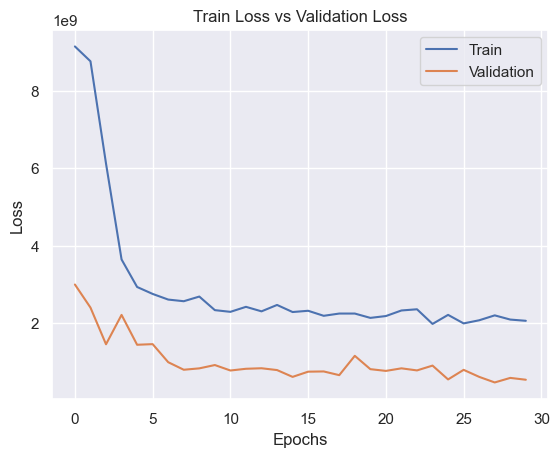

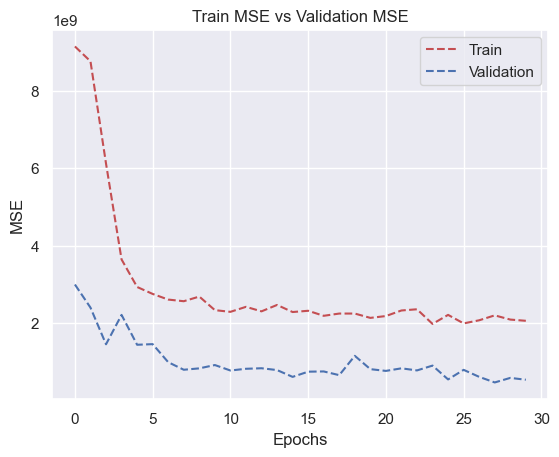

In [220]:
# Plot for train vs. validation loss
nn_hist = pd.DataFrame(nn_history_callback.history)
fig, loss_ax = plt.subplots ()
loss_ax.plot(nn_hist.index, nn_hist["loss"], label="Train")
loss_ax.plot(nn_hist.index, nn_hist["val_loss"], label="Validation")
loss_ax.set_ylabel("Loss")
loss_ax.set_xlabel("Epochs")

loss_ax.legend()

loss_ax.set_title("Train Loss vs Validation Loss")
plt.show()

# Plot for train vs. validation MSE
fig, mse_ax = plt.subplots ()
mse_ax.plot(nn_hist.index, nn_hist["mean_squared_error"], 'r--', label="Train") 
mse_ax.plot(nn_hist.index, nn_hist["val_mean_squared_error"], 'b--', label="Validation")
mse_ax.set_ylabel("MSE")
mse_ax.set_xlabel("Epochs")

mse_ax.legend()

mse_ax.set_title("Train MSE vs Validation MSE")
plt.show()

In [221]:
test_score = nn.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_score[0]:.4f}")

Test Loss: 2037488768.0000


### **L2 Regularization and Dropout Integration**

Our input shape is the number of features we have in the dataset.

In [222]:
input_shape = (X_train.shape[1],) 

In [223]:
nn_l2_dropout = Sequential()

# hidden layer (with l2 and dropout)
nn_l2_dropout.add(Dense(128, input_shape=input_shape, activation='relu', kernel_regularizer=l2(0.001))) 
nn_l2_dropout.add(Dropout(0.2))  

# hidden layer (with l2 and dropout)
nn_l2_dropout.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01))) 
nn_l2_dropout.add(Dropout(0.2)) 

# output
nn_l2_dropout.add(Dense(1))  


/Users/sadievilla/F2024/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Compile New L2 Model**

We use **adam** as the optimizer and we will look at performance using mean squared error.

In [224]:
nn_l2_dropout.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])

nn_l2_dropout.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,249 (83.00 KB)

 Trainable params: 21,249 (83.00 KB)

 Non-trainable params: 0 (0.00 B)

In [225]:
l2_dropout_history_callback = nn_l2_dropout.fit(X_train, y_train, batch_size=32, epochs=40, verbose=1, validation_split=0.2) 

Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10290621440.0000 - mean_squared_error: 10290621440.0000 - val_loss: 5100047360.0000 - val_mean_squared_error: 5100047360.0000
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7854500352.0000 - mean_squared_error: 7854500352.0000 - val_loss: 5099702784.0000 - val_mean_squared_error: 5099702784.0000
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10301040640.0000 - mean_squared_error: 10301040640.0000 - val_loss: 5099094528.0000 - val_mean_squared_error: 5099095040.0000
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7295341056.0000 - mean_squared_error: 7295341056.0000 - val_loss: 5098078720.0000 - val_mean_squared_error: 5098078720.0000
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7633935360.0000 - mean_squared_error: 7633935360.0000 - val_loss: 5096450560.0000 - val_mean_squared_error: 5096450560.0000
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9334119424.0000 - mean_squar

In [226]:
train_mse = l2_dropout_history_callback.history["mean_squared_error"]
train_loss = l2_dropout_history_callback.history["loss"]
val_mse = l2_dropout_history_callback.history["val_mean_squared_error"]
val_loss = l2_dropout_history_callback.history["val_loss"]

for epoch in range(40):
    print(f"Epoch {epoch+1}:\nTrain MSE: {train_mse[epoch]}\nValidation MSE: {val_mse[epoch]}\nTrain Loss: {train_loss[epoch]}\nValidation Loss: {val_loss[epoch]}")

Epoch 1:
Train MSE: 9398321152.0
Validation MSE: 5100047360.0
Train Loss: 9398321152.0
Validation Loss: 5100047360.0
Epoch 2:
Train MSE: 9397923840.0
Validation MSE: 5099702784.0
Train Loss: 9397923840.0
Validation Loss: 5099702784.0
Epoch 3:
Train MSE: 9397389312.0
Validation MSE: 5099095040.0
Train Loss: 9397389312.0
Validation Loss: 5099094528.0
Epoch 4:
Train MSE: 9396332544.0
Validation MSE: 5098078720.0
Train Loss: 9396332544.0
Validation Loss: 5098078720.0
Epoch 5:
Train MSE: 9394459648.0
Validation MSE: 5096450560.0
Train Loss: 9394459648.0
Validation Loss: 5096450560.0
Epoch 6:
Train MSE: 9392054272.0
Validation MSE: 5093673984.0
Train Loss: 9392054272.0
Validation Loss: 5093673984.0
Epoch 7:
Train MSE: 9388382208.0
Validation MSE: 5089481216.0
Train Loss: 9388382208.0
Validation Loss: 5089481216.0
Epoch 8:
Train MSE: 9382412288.0
Validation MSE: 5083259392.0
Train Loss: 9382412288.0
Validation Loss: 5083259392.0
Epoch 9:
Train MSE: 9373002752.0
Validation MSE: 5075038720.0
Tr

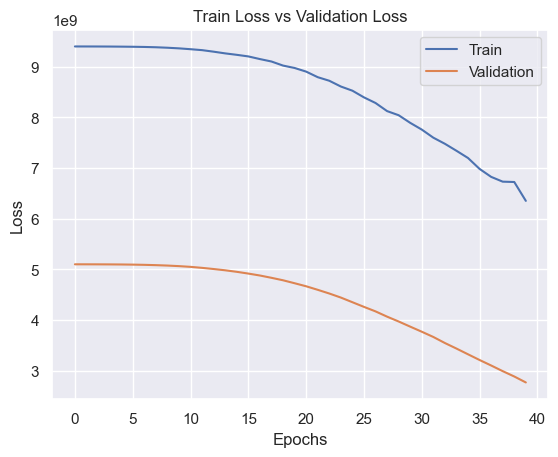

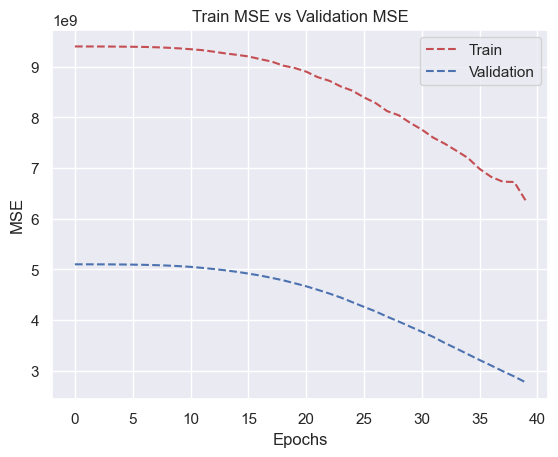

In [227]:
# Plot for train vs. validation loss
l2_dropout_nn_hist = pd.DataFrame(l2_dropout_history_callback.history)
fig, loss_ax = plt.subplots ()
loss_ax.plot(l2_dropout_nn_hist.index, l2_dropout_nn_hist["loss"], label="Train")
loss_ax.plot(l2_dropout_nn_hist.index, l2_dropout_nn_hist["val_loss"], label="Validation")
loss_ax.set_ylabel("Loss")
loss_ax.set_xlabel("Epochs")

loss_ax.legend()

loss_ax.set_title("Train Loss vs Validation Loss")
plt.show()

# Plot for train vs. validation MSE
fig, mse_ax = plt.subplots ()
mse_ax.plot(l2_dropout_nn_hist.index, l2_dropout_nn_hist["mean_squared_error"], 'r--', label="Train") 
mse_ax.plot(l2_dropout_nn_hist.index, l2_dropout_nn_hist["val_mean_squared_error"], 'b--', label="Validation")
mse_ax.set_ylabel("MSE")
mse_ax.set_xlabel("Epochs")

mse_ax.legend()

mse_ax.set_title("Train MSE vs Validation MSE")
plt.show()

**Evaluate model performance on test set**

In [228]:
test_score = nn_l2_dropout.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_score[0]:.4f}")


Test Loss: 6415259136.0000


# IV. Classification

The variable we predicted, market cap, is one of several financial metrics that indicate a company's financial outlook. Profitability is one of the more important metrics tied to market capitalization because investors can look for cash flow generation that they assume will be distirbuted to them. Therefore, higher profitability indicates a higher likelihood of dividend distribution that would boost a company's market capitalization. 

For this reason, we chose **profitability** for our classification task. 

**Collection of Models**

Here, we will train a collection of classification models and create a single function to evaluate them. For classifying companies by profitability, we will implement the following models.

In [229]:
# Examine class imbalance
profitable_count = len(df[df["Profitable_yes"] == 1]) / len(df)
non_profitable_count = 1 - profitable_count
print(f"Class Distribution:\nProfitable: {profitable_count:.4f}\nNon-Profitable: {non_profitable_count:.4f}")


Class Distribution:
Profitable: 0.8571
Non-Profitable: 0.1429


**Explanation**

Imbalanced data is to be expected, as Fortune1000 will often fall within the "Profitable" category. However, we will apply techniques later on (such as SMOTE) to handle this data imbalance and any potential misclassifications.

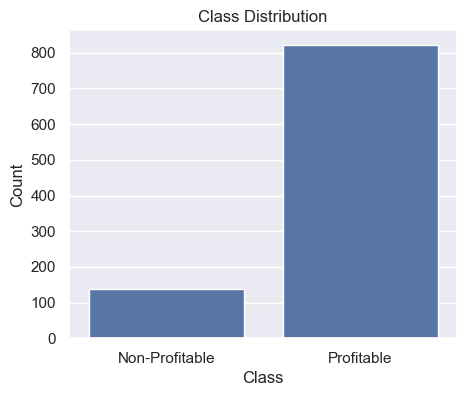

In [230]:
# Visualize class distribution


plt.figure(figsize=(5, 4))
sns.countplot(x="Profitable_yes", data=df)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ["Non-Profitable", "Profitable"])


plt.show()


In [231]:
# Drop irrelevant columns (adjust based on your dataset)
df = df.drop(["Time"], axis=1, errors="ignore")

# Apply necessary transformations (e.g., log-transform if needed for skewed features)
df["Log Revenue"] = np.log(df["Revenues_M"] + 0.001)
df["Log EBITDA"] = np.log(df["EBITDA"] + 0.001)
df = df.drop(columns=["Revenues_M", "EBITDA"])

/Users/sadievilla/F2024/myenv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Splitting the Data

We will use *Straified Splitting* to split the data into an 80/20 split. We are using stratified splitting due to the significant class imbalance. Stratified splitting preserves the class proportions amidst splitting the dataset into test and development sets. The proportion of profitable to non-profitable companies in our original dataset should be better represented in our now-split datasets after using this type of splitting.

In [232]:
# Split data using stratified split
X = df.drop(columns=["Profitable_yes"])
y = df["Profitable_yes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Scale the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Confirm split shapes
print(f"\nShape of Training Set:\n{X_train.shape}, {y_train.shape}")
print(f"\nShape of Test Set:\n{X_test.shape}, {y_test.shape}")


Shape of Training Set:
(767, 100), (767,)

Shape of Test Set:
(192, 100), (192,)


## Decision Tree Classification

In [233]:
# Default classifier


pipe_default = make_pipeline(DecisionTreeClassifier(max_depth=10, random_state=42))
default_scores = cross_validate(pipe_default, X_train, y_train, cv=5, scoring=["roc_auc", "average_precision"])
print(f"Default Model:\nAUC: {default_scores['test_roc_auc'].mean():.4f}\nAverage Precision: {default_scores['test_average_precision'].mean():.4f}")


Default Model:
AUC: 0.8727
Average Precision: 0.9604


In [234]:
# Balanced weights classifier
pipe_balanced = make_pipeline(DecisionTreeClassifier(max_depth=10, random_state=42, class_weight="balanced"))
balanced_scores = cross_validate(pipe_balanced, X_train, y_train, cv=5, scoring=["roc_auc", "average_precision"])
print(f"Balanced Model:\nAUC: {balanced_scores['test_roc_auc'].mean():.4f}\nAverage Precision: {balanced_scores['test_average_precision'].mean():.4f}")


Balanced Model:
AUC: 0.9040
Average Precision: 0.9692


In [235]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

pipe_ros = make_pipeline(DecisionTreeClassifier(max_depth=10, random_state=42))
ros_scores = cross_validate(pipe_ros, X_train_ros, y_train_ros, cv=5, scoring=["roc_auc", "average_precision"])
print(f"Random Oversampling Model:\nAUC: {ros_scores['test_roc_auc'].mean():.4f}\nAverage Precision: {ros_scores['test_average_precision'].mean():.4f}")

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

pipe_rus = make_pipeline(DecisionTreeClassifier(max_depth=10, random_state=42))
rus_scores = cross_validate(pipe_rus, X_train_rus, y_train_rus, cv=5, scoring=["roc_auc", "average_precision"])
print(f"Random Undersampling Model:\nAUC: {rus_scores['test_roc_auc'].mean():.4f}\nAverage Precision: {rus_scores['test_average_precision'].mean():.4f}")


Random Oversampling Model:
AUC: 0.9824
Average Precision: 0.9824
Random Undersampling Model:
AUC: 0.9636
Average Precision: 0.9480


### Synthetic Minority Oversampling (SMOTE)

We used SMOTE to balance the class distribution due to the fact that non-profitable companies are the minority amongst Fortune1000 companies. Otherwise, without SMOTE, the model may struggle classifying non-profitable companies. 


We will introduce synthetic samples for the minority class (non-profitabitly) so that the non-profitable companies are correctly identified. Our goal in doing this is to reduce overfitting and get better model accuracy. 

In [236]:
## converting back into a dataframe for SMOTE 

X_train = pd.DataFrame(X_train).reset_index(drop=True)

X_train = X_train.dropna()
y_train = y_train.reset_index(drop=True)  
y_train = y_train.loc[X_train.index]   

In [237]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

pipe_smote = make_pipeline(DecisionTreeClassifier(max_depth=10, random_state=42))
smote_scores = cross_validate(pipe_smote, X_train_smote, y_train_smote, cv=5, scoring=["roc_auc", "average_precision"])
print(f"SMOTE Model:\nAUC: {smote_scores['test_roc_auc'].mean():.4f}\nAverage Precision: {smote_scores['test_average_precision'].mean():.4f}")


SMOTE Model:
AUC: 0.9587
Average Precision: 0.9435


**Explanation**

The model has a fairly high precision of 0.94. This shows that the model performs well with finding the profitable companies without having many false positives.

**Which metric do we prioritize?**: For this task, we are prioritizing recall because the goal is to identify more profitable companies. Therefore, it is ideal for us to have this high average precision!

### Evaluation

Here, we will evaluate each model using ROC_AUC scores.

In [238]:
## Evaluation 

models = {
    "Default": pipe_default,
    "Balanced": pipe_balanced,
    "Random Oversampling": pipe_ros,
    "Random Undersampling": pipe_rus,
    "SMOTE": pipe_smote
}

for model_name, model in models.items():
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name} Test AUC: {auc:.4f}")

Default Test AUC: 0.9247
Balanced Test AUC: 0.9256
Random Oversampling Test AUC: 0.9247
Random Undersampling Test AUC: 0.9247
SMOTE Test AUC: 0.9247


### Confusion Matrices

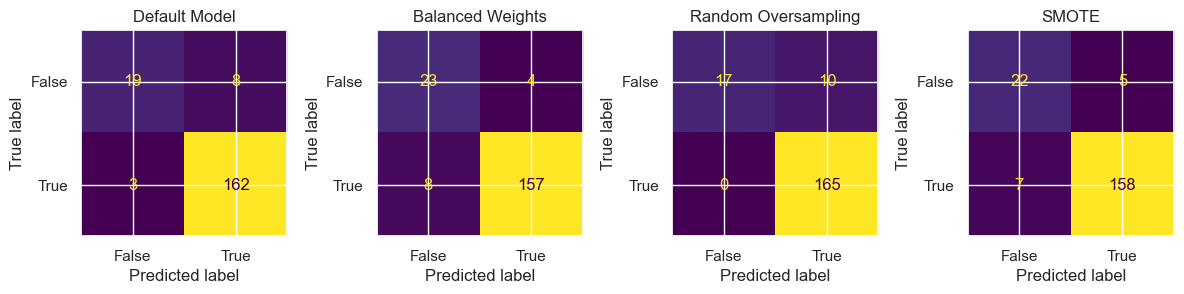

In [ ]:
models = {
    "Default Model": DecisionTreeClassifier(random_state=42),
    "Balanced Weights": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Random Oversampling": RandomForestClassifier(random_state=42),
    "SMOTE": RandomForestClassifier(random_state=42),
}

oversampler = SMOTE(random_state=42)
X_train_smote, y_train_smote = oversampler.fit_resample(X_train, y_train)
pred = {}

for model_name, model in models.items():

    if model_name == "SMOTE":
        model.fit(X_train_smote, y_train_smote)

    else:
        model.fit(X_train, y_train)
    pred[model_name] = model.predict(X_test)


fig, axes = plt.subplots(1, len(models), figsize=(12, 7))
for ax, (model_name, y_pred) in zip(axes, pred.items()):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)

    
    ax.set_title(model_name)

plt.tight_layout()
plt.show()

### Explanation of the Confusion Matrices


**Quick Summarization of the Numbers**:

Balanced Weight:
153 True Positives: Classifies a fairly large number of profitable companies correctly.
24 True Negatives: Only a small number of non-profitable companies are correctly identified.
3 False Positives : Very few non-profitable companies are wrongly labeled as profitable.
12 False Negatives: Misses a moderate number of profitable companies, misclassifying them as non-profitable.

Random Oversampling:
162 True Positives: The most profitable companies are correctly classified with this model!
3 False Negatives: Rarely misclassifies profitable companies.
8False Positives: Misclassifies more non-profitable companies as profitable.
19 True Negatives: A bit fewer non-profitable companies are correctly classified compared to Balanced Weight.

Random Undersampling:
162True Positives: Matches oversampling with the highest number of correctly identified profitable companies.
3 False Negatives: Same as oversampling—rarely misses profitable companies.
19 True Negatives: Matches oversampling in the number of correctly identified non-profitable companies.
8 False Positives: Also matches oversampling in the number of misclassified non-profitable companies.

SMOTE:
Similar performance can be seen across all the performance metrics!



**Plot of ROC curve**

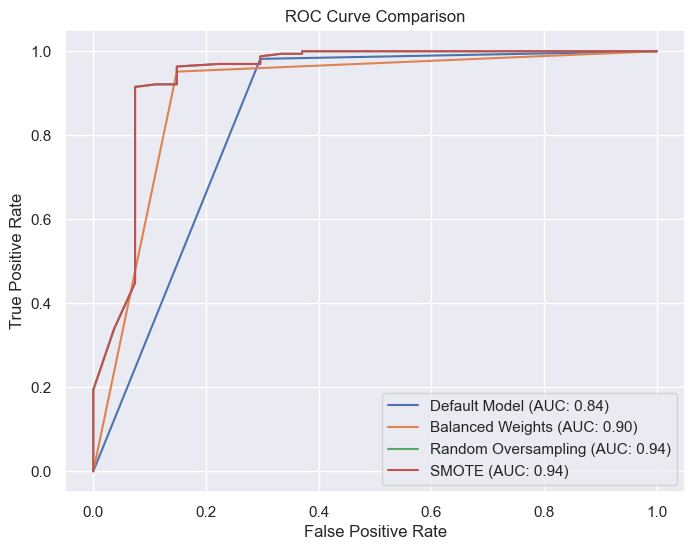

In [241]:
plt.figure(figsize=(8, 6))

for model_name, model in models.items():
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC: {auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")


plt.legend()
plt.show()

**Explanation of Curves**

We can see from the curves that our Balanced weight model achieves the highest AUC of 0.93 of compared to other techniques. This indicates that this model may have better balance between true and false positive rates. The other techniques clearly have very similar performance, and we can see that they perform similarly in ranking positive cases by their close AUC scores of 0.92. This very small difference in performance could be because of how they perform with the decision tree classifier.

Generally, all of our models are above 0.50, and the balanced model is overall the best technique to use for our scenario, but the difference is minimal compared to the other model performances ~0.92.


---

### **Regression**
We developed three different regression models to predict market cap based on financial metrics like revenue, EBITDA, profit changes, assets, and other metrics from our dataset. The data preprocessing steps included handling missing values, handling multicollinearity, handling outliers/skewed data, encoding categorical variables, and scaling numerical features.

1. **Linear Regression**: In our first deliverable, we outlined that we wanted to potentially start with a baseline model like Linear Regression and incorporate other models from that point. Our performance from this model was fairly moderate (our test R² was around 0.73).
2. **Ridge Regression**: Given how imbalanced financial data typically is, we wanted to incorporate ridge regression (outlined in Deliverable 2). Hyperparameter tuning definitley improved the model and helped us with achieving slightly higher R² scores on validation and test sets.
3. **Neural Networks**: Similar to linear regression, we developed a baseline model and then added a penalty due to the nature of our dataset. We integrated dropout and L2 regularization, and, after tuning, this resulted in better model performance.


---

### **Classification**
Our classification task invovled identifying profitable vs. non-profitable companies. Given our imbalanced data, with most companies categorized as profitable, we applied techniques such as balanced class weights, random oversampling, random undersampling, and SMOTE.

1. **Balanced Weights:** we can see that this model prioritizes precision and recall (our goal) but leans towards precision for the minority class (non-profitable).
- This model does well at identifying profitable companies (153 true positives) but struggles slightly with non-profitable ones (24 true negatives).
- The model has few non-profitable companies are incorrectly flagged as profitable (only 3 false positives) but it misclassifies some profitable companies as non-profitable (12 false negatives).

2. **Random Oversampling:** Has higher recall for profitable companies but at the cost of slightly reduced precision. However, trades off some precision.
- This model is the best at identifying profitable companies (162 true positives)
- The model also has almost no profitable companies misclassified (3 false negatives).
- This model performs somewhat well identifying non-profitable companies (19 true negatives).
- Has some misclassifications (8 false positives).

3. **Random Undersampling:** Prioritizes recall (like oversampling) 
- Similar to oversampling, it has strong recall for profitable companies (162 true positives and 3 false negatives).
- May result in non-profitable companies being misclassified as profitable (8 false positives with 19 true negatives).

4. **SMOTE:**
- This model has very similar the performance with oversampling and undersampling. There are only small differences in results.

**ROC:**
Looking into ROC showed us minimal differences in techniques, where all models achieving AUC scores around or slightly above 0.92. The balanced weight model performed slightly better (AUC: 0.93), indicating it might be the most appropriate choice for our tasks given the data's characteristics and our primary objective to balance precision and recall.

---

## Final Thoughts

We used regression and classification to predict market cap, which represents company stock price and shares outstanding, and company profitability, which is an indicator of growth, company health, and potential growth. Our regression models showed that industry metrics, such as the ones in our dataset, can help us predict market capitalization. Our classification models similarly showed that we can observe certain characteristics about companies' financials, but based on their classification as a profitable or non-profitable company.

* Feature importance analysis highlighted that revenue, EBITDA margins, and industry type were key drivers of market cap.
* Certain industries and sectors may be tied to market cap value. For example, we saw an interesting case of healthcare/pharmacuetical company influence on market cap. 
* Most Fortune1000 companies are categorized as profitable (as expected).
